<a href="https://colab.research.google.com/github/Louis5228/Mechine-Learning/blob/main/309512014_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import os
from google.colab import drive
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math
from numpy.linalg import inv, pinv, linalg
drive.mount('/content/gdrive')

data = pd.read_csv("/content/gdrive/My Drive/Machine_Learning/HW2/dataset/data.csv")
data = np.array(data)
x = data[:, :1]
t = data[:, 1:]

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [16]:
M = 3
s = 0.6
N_list = [5, 10, 30, 80]
N_index = [0, 5, 10, 30, 80]
beta = 1
m0 = np.zeros((M,1))
s0_inv = math.pow(10,-6)*np.eye(M)

def sigmoid_f(a):
  return 1 / (1 + np.exp(-a))

def cal_phi(x):
  phi = np.empty([len(x),0])
  for j in range(M):
    mu = 2*j / M
    phi = np.hstack((phi, sigmoid_f((x - mu) / s)))
  return phi

def posterior_dist(m0, s0_inv, beta, phi, t):
  sN_inv = s0_inv + beta*np.dot(phi.T, phi)
  sN = inv(sN_inv)
  mN = np.dot(sN, (np.dot(s0_inv, m0) + beta*np.dot(phi.T, t)))
  return mN, sN

mN_l = []
sN_l = []
for i in range(1, len(N_index)):
  x_temp = x[N_index[i-1]:N_index[i]]
  t_temp = t[N_index[i-1]:N_index[i]]
  mN, sN = posterior_dist(m0, s0_inv, beta, cal_phi(x_temp), t_temp)
  mN_l.append(mN)
  sN_l.append(sN)
  # print("Data size:", N_index[i], "\nmean:\n", mN, "\nconvariance:\n", sN, "\n")

  m0 = mN
  s0_inv = inv(sN)

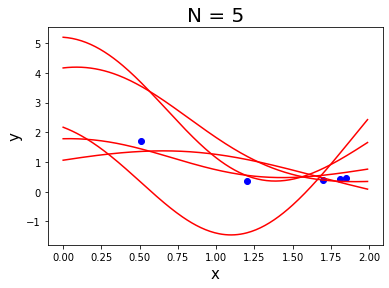

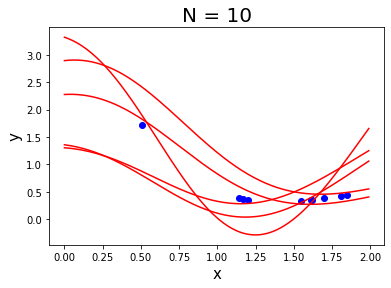

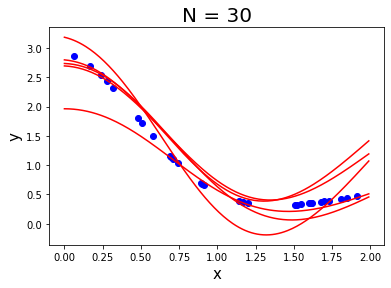

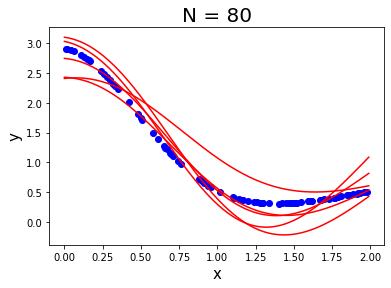

In [71]:
curve_num = 5
sample_x = np.arange(0, 2, 0.01).reshape(200,1)

for i in range(len(N_list)):
  plt.title('N = ' + str(N_list[i]), fontsize = 20)
  plt.xlabel('x', fontsize = 15)
  plt.ylabel('y', fontsize = 15)
  for j in range(N_list[i]):
    plt.scatter(x[j], t[j], color='blue')
  for k in range(curve_num):
    w = np.random.multivariate_normal(mN_l[i][:,0], sN_l[i], 1)
    y = np.dot(w, cal_phi(sample_x).T)
    plt.plot(sample_x, y.T, color='red')
  plt.show()